# Merging/Cleaning data

Merging all the info in the stations into a small and compact number of pandas dataframes. There are three metereologic stations in Temuco: 'Las Encinas', 'Padre Las Casas II' and 'Ñielol'

In [1]:
import glob
import numpy as np
import pandas as pd
import seaborn
import missingno
import matplotlib.pyplot as plt
from datetime import date, datetime


Functions to standarize time format:

In [2]:
# Data Transformation functions from preprocessing.py
def get_season(date_time):
    """
    This function takes a datetime object and determines the season
    :param date_time: datetime object
    :return: season str
    """
    # dummy leap year to include leap days(year-02-29) in our range
    leap_year = 2000
    seasons = [('verano', (date(leap_year, 1, 1), date(leap_year, 3, 20))),
               ('otoño', (date(leap_year, 3, 21), date(leap_year, 6, 20))),
               ('invierno', (date(leap_year, 6, 21), date(leap_year, 9, 22))),
               ('primavera', (date(leap_year, 9, 23), date(leap_year, 12, 20))),
               ('verano', (date(leap_year, 12, 21), date(leap_year, 12, 31)))]

    if isinstance(date_time, datetime):
        date_time = date_time.date()
    # we don't really care about the actual year so replace it with our dummy leap_year
    date_time = date_time.replace(year=leap_year)
    # return season our date falls in.
    return next(season for season, (start, end) in seasons
                if start <= date_time <= end)

def create_season_column(data_set, date_column):
    """
    takes the get_season function and uses it to apply it in a df
    :param data_set: pandas df
    :param date_column: name of the column with the datetime objs
    :return: pandas df with the new column
    """
    # cloning the input dataset.
    local = data_set.copy()
    # The apply method calls a function on each row
    local['Estacion'] = local[date_column].apply(get_season)
    return local

#Has slight changes from preprocessing.py to match the for loop format
def open_df(path):
    """
    Opens a generic csv of sinca
    :param path: path of the csv
    :return: returns a pandas df
    """
    datetime_format = {'FECHA (YYMMDD)': str, 'HORA (HHMM)': str}
    df = pd.read_csv(path, sep=';', dtype=datetime_format, decimal=',')
    df['datetime'] = pd.to_datetime(df['FECHA (YYMMDD)'] + ':' + df['HORA (HHMM)'], format='%y%m%d:%H%M')
    df.drop('Unnamed: 3', axis=1, inplace=True)
    df.drop(['FECHA (YYMMDD)','HORA (HHMM)'], axis=1, inplace=True)
    return df


def multi_date(df):
    """
    takes a pd df and makes a multiindex and aplies the season
    :param df: df to apply on
    :return: df with the multi index and season
    """
    df = create_season_column(df, date_column='datetime')
    df.index = pd.MultiIndex.from_arrays([df.datetime.dt.year,
                                          df.datetime.dt.month,
                                          df.datetime.dt.day,
                                          df.datetime.dt.time],
                                          names=['Year', 'Month', 'Day','Time'])
    df= df[['datetime','Estacion','Unnamed: 2']]
    return df



## Las Encinas

Merge all the information of "Las Encinas" station.


In [3]:
path = r'C:\Users\user\Desktop\Universidad\Machine-Learning\Proyecto\Proyecto_ML_MP2.5\data\estacion-las-encinas' # use your path
las_encinas_files = glob.glob(path + "/*.csv")

#given a list of filenames containing all the readings from a SINCA Metereologic Station, with the filename in format "stationName _ meteorologicReading_ metersOfAltitudeOfMeasurement",
#delivers a single dataframe containing all the readings, with a more suited time format for the readings.
def get_station_dataframe(file_list):
    #First we create a list of dataframes that contains all the information of the station 
    li = []
    for filename in file_list:
        df = open_df(filename)
        df= multi_date(df) #to view the time data in a cleaner way
        if "velocidad_viento" in filename:
            if "10m" in filename:
                df=df.rename(columns= {"Unnamed: 2": "Velocidad Viento 10m"})
            elif "SI" in filename:
                df=df.rename(columns= {"Unnamed: 2": "Velocidad Viento S.I."})
            li.append(df)
        elif "direccion_viento" in filename:
            if "10m" in filename:
                df=df.rename(columns= {"Unnamed: 2": "Direccion Viento 10m"})
            elif "SI" in filename:
                df=df.rename(columns= {"Unnamed: 2": "Direccion Viento S.I."})
            li.append(df)
        elif "humedad_relativa" in filename:
            if "2m" in filename:
                df=df.rename(columns= {"Unnamed: 2": "Humedad Relativa 2m"})
            elif "3m" in filename:
                df=df.rename(columns= {"Unnamed: 2": "Humedad Relativa 3m"})
            elif "SI" in filename:
                df=df.rename(columns= {"Unnamed: 2": "Humedad Relativa S.I."})
            li.append(df)
        elif "presion_atmosferica" in filename:
            if "2m" in filename:
                df=df.rename(columns= {"Unnamed: 2": "Presion Atmosferica 2m"})
            elif "3m" in filename:
                df=df.rename(columns= {"Unnamed: 2": "Presion Atmosferica 3m"})
            elif "SI" in filename:
                df=df.rename(columns= {"Unnamed: 2": "Presion Atmosferica S.I."})
            li.append(df)    
        elif "precipitaciones" in filename:
            if "2m" in filename:
                df=df.rename(columns= {"Unnamed: 2": "Precipitaciones 2m"})
            elif "4m" in filename:
                df=df.rename(columns= {"Unnamed: 2": "Precipitaciones 4m"})
            elif "SI" in filename:
                df=df.rename(columns= {"Unnamed: 2": "Precipitaciones S.I."})                
            li.append(df)
        elif "temperatura_ambiente" in filename:
            if "2m" in filename:
                df=df.rename(columns= {"Unnamed: 2": "Temperatura Ambiente 2m"})
            elif "10m" in filename:
                df=df.rename(columns= {"Unnamed: 2": "Temperatura Ambiente 10m"})
            elif "SI" in filename:
                df=df.rename(columns= {"Unnamed: 2": "Temperatura Ambiente S.I."})
            li.append(df)

    #Now we merge the dataframes on datetime        
    merged_df=li[0]        
    for dataframe in li[1:len(li)]:
        merged_df=pd.merge(merged_df, dataframe, how='outer', on=["datetime","Estacion"])
        
    return merged_df
    
#df las encinas and dataframe list
df_le = get_station_dataframe(las_encinas_files)

In [4]:
df_le

,datetime,Estacion,Direccion Viento 10m,Direccion Viento S.I.,Humedad Relativa 2m,Humedad Relativa 3m,Humedad Relativa S.I.,Precipitaciones 2m,Precipitaciones 4m,Precipitaciones S.I.,Presion Atmosferica 2m,Presion Atmosferica 3m,Presion Atmosferica S.I.,Temperatura Ambiente 10m,Temperatura Ambiente 2m,Temperatura Ambiente S.I.,Velocidad Viento 10m,Velocidad Viento S.I.
0,2004-03-31 01:00:00,otoño,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2004-03-31 02:00:00,otoño,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2004-03-31 03:00:00,otoño,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2004-03-31 04:00:00,otoño,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2004-03-31 05:00:00,otoño,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143442,2020-08-10 19:00:00,invierno,233.2910,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
143443,2020-08-10 20:00:00,invierno,358.9530,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
143444,2020-08-10 21:00:00,invierno,53.4640,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
143445,2020-08-10 22:00:00,invierno,30.7447,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Dealing with Nans

In order to see how to deal with missing information in a more intuitive way, we use the missigno library.

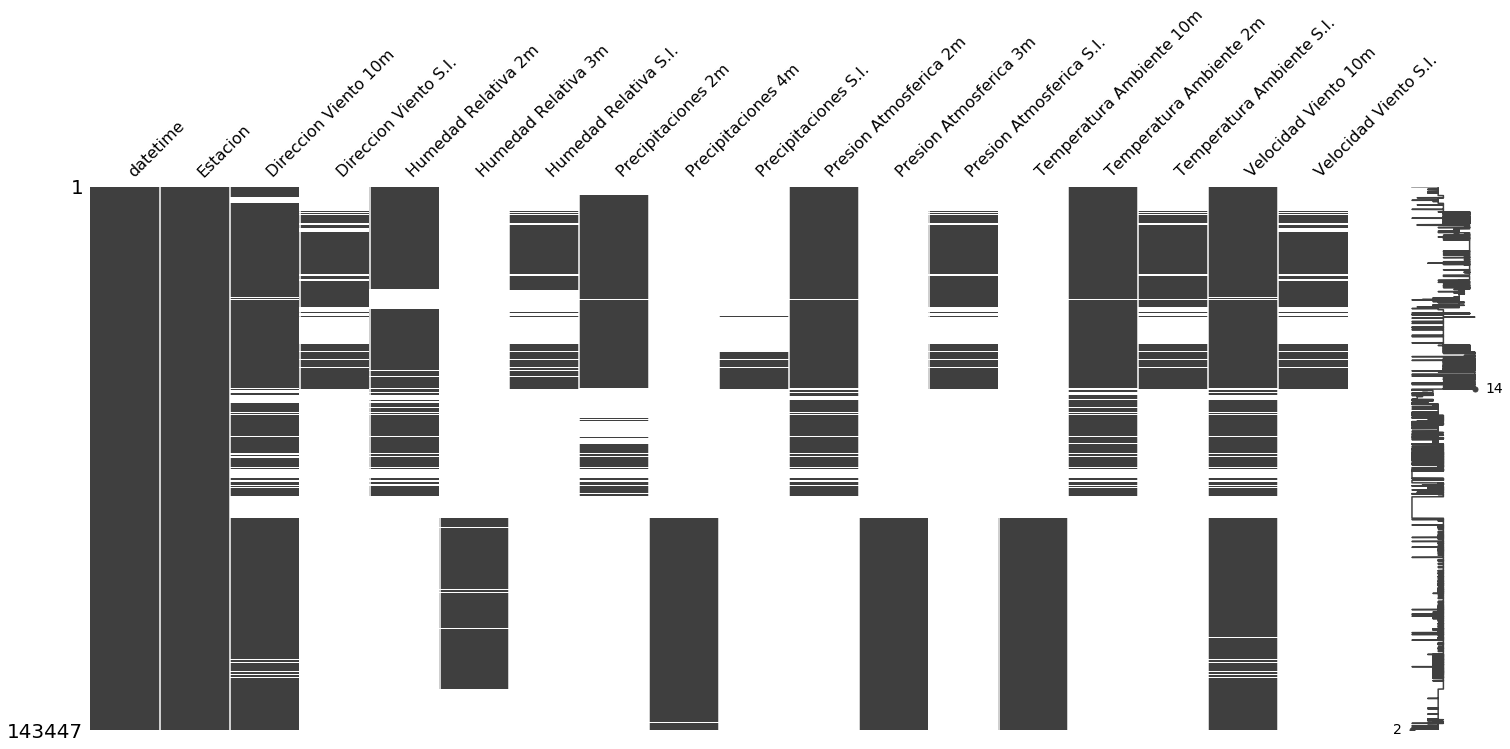

In [5]:
missingno.matrix(df_le)

C:\Users\user\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


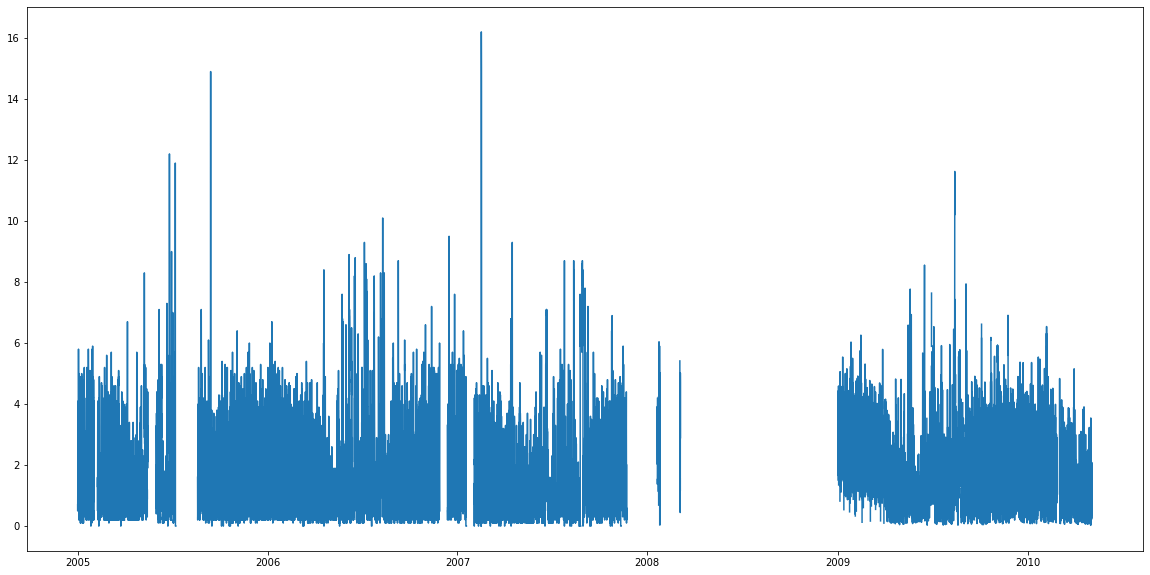

In [6]:
plt.figure(figsize=(20,10))
plt.plot(df_le['datetime'], df_le['Velocidad Viento S.I.'])

C:\Users\user\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


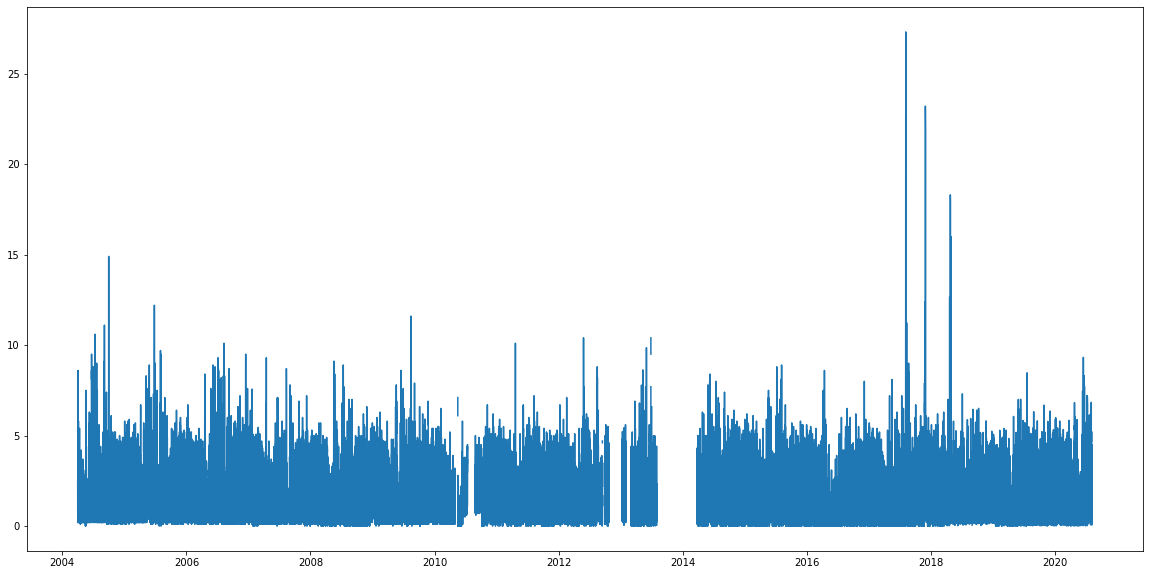

In [7]:
plt.figure(figsize=(20,10))
plt.plot(df_le['datetime'], df_le['Velocidad Viento 10m'])

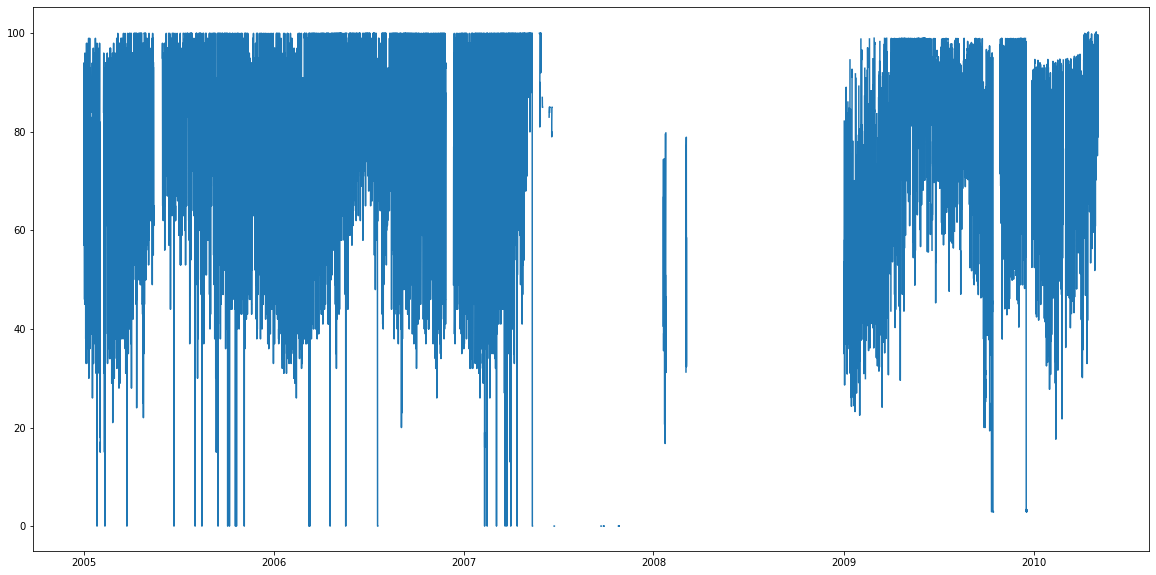

In [8]:
plt.figure(figsize=(20,10))
plt.plot(df_le['datetime'], df_le['Humedad Relativa S.I.'])

The resemblance on the meditions made at different meters motivate us to "patch them" into one column, for better handling of Nans.

In [7]:
#Humedad Relativa
df_le["humedad_relativa"] = df_le["Humedad Relativa 2m"].combine_first(df_le["Humedad Relativa 3m"]).astype(float)
df_le["humedad_relativa"] = df_le["humedad_relativa"].combine_first(df_le["Humedad Relativa S.I."]).astype(float)
df_le= df_le.drop(['Humedad Relativa 2m', 'Humedad Relativa 3m','Humedad Relativa S.I.'], axis=1)

#Velocidad Viento
df_le["velocidad_viento"] = df_le["Velocidad Viento 10m"].combine_first(df_le["Velocidad Viento S.I."]).astype(float)
df_le= df_le.drop(['Velocidad Viento 10m', 'Velocidad Viento S.I.'], axis=1)

#Direccion Viento
df_le["direccion_viento"] = df_le["Direccion Viento 10m"].combine_first(df_le["Direccion Viento S.I."]).astype(float)
df_le= df_le.drop(['Direccion Viento 10m', 'Direccion Viento S.I.'], axis=1)

#Precipitacion
df_le["precipitaciones"] = df_le["Precipitaciones 2m"].combine_first(df_le["Precipitaciones 4m"]).astype(float)
df_le["precipitaciones"] = df_le["precipitaciones"].combine_first(df_le["Precipitaciones S.I."]).astype(float)
df_le= df_le.drop(['Precipitaciones 4m','Precipitaciones 2m','Precipitaciones S.I.'], axis=1)
#Presion Atmosferica
df_le["presion_atmosferica"] = df_le["Presion Atmosferica 2m"].combine_first(df_le["Presion Atmosferica 3m"]).astype(float)
df_le["presion_atmosferica"] = df_le["presion_atmosferica"].combine_first(df_le["Presion Atmosferica S.I."]).astype(float)
df_le= df_le.drop(['Presion Atmosferica 2m','Presion Atmosferica 3m','Presion Atmosferica S.I.'], axis=1)
#Temperatura Ambiente 
df_le["temperatura_ambiente"] = df_le["Temperatura Ambiente 10m"].combine_first(df_le["Temperatura Ambiente 2m"]).astype(float)
df_le["temperatura_ambiente"] = df_le["temperatura_ambiente"].combine_first(df_le["Temperatura Ambiente S.I."]).astype(float)
df_le= df_le.drop(['Temperatura Ambiente 10m','Temperatura Ambiente 2m','Temperatura Ambiente S.I.'], axis=1)


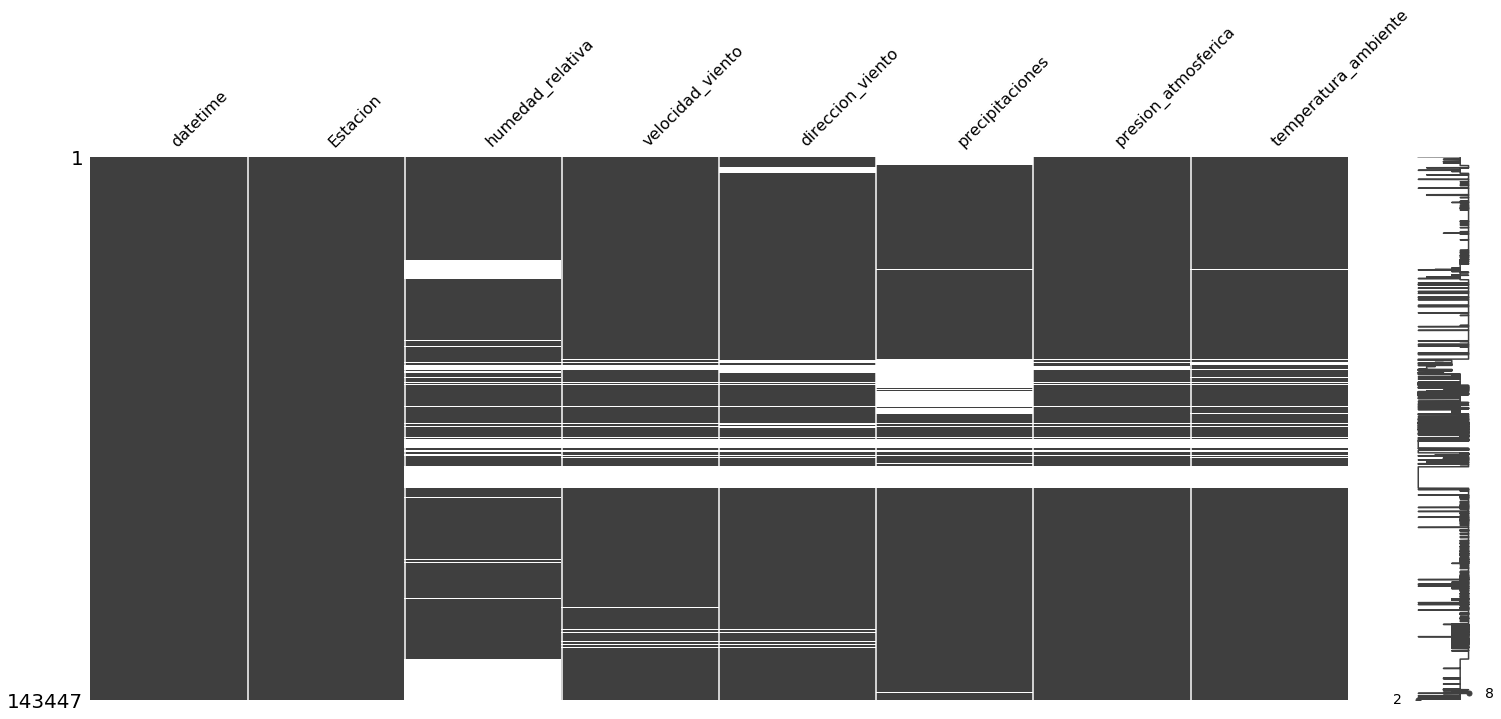

In [9]:
missingno.matrix(df_le)

In [33]:
#dropping rows where all the metereologic metrics are 'nan'
df_le.dropna(how='all',subset=["humedad_relativa","velocidad_viento","direccion_viento","precipitaciones", "presion_atmosferica","temperatura_ambiente"], inplace=True)
df_le.dropna(how='all',subset=["precipitaciones"], inplace=True)
df_le.dropna(how='all',subset=["velocidad_viento"], inplace=True)
df_le.dropna(how='all',subset=["direccion_viento"], inplace=True)




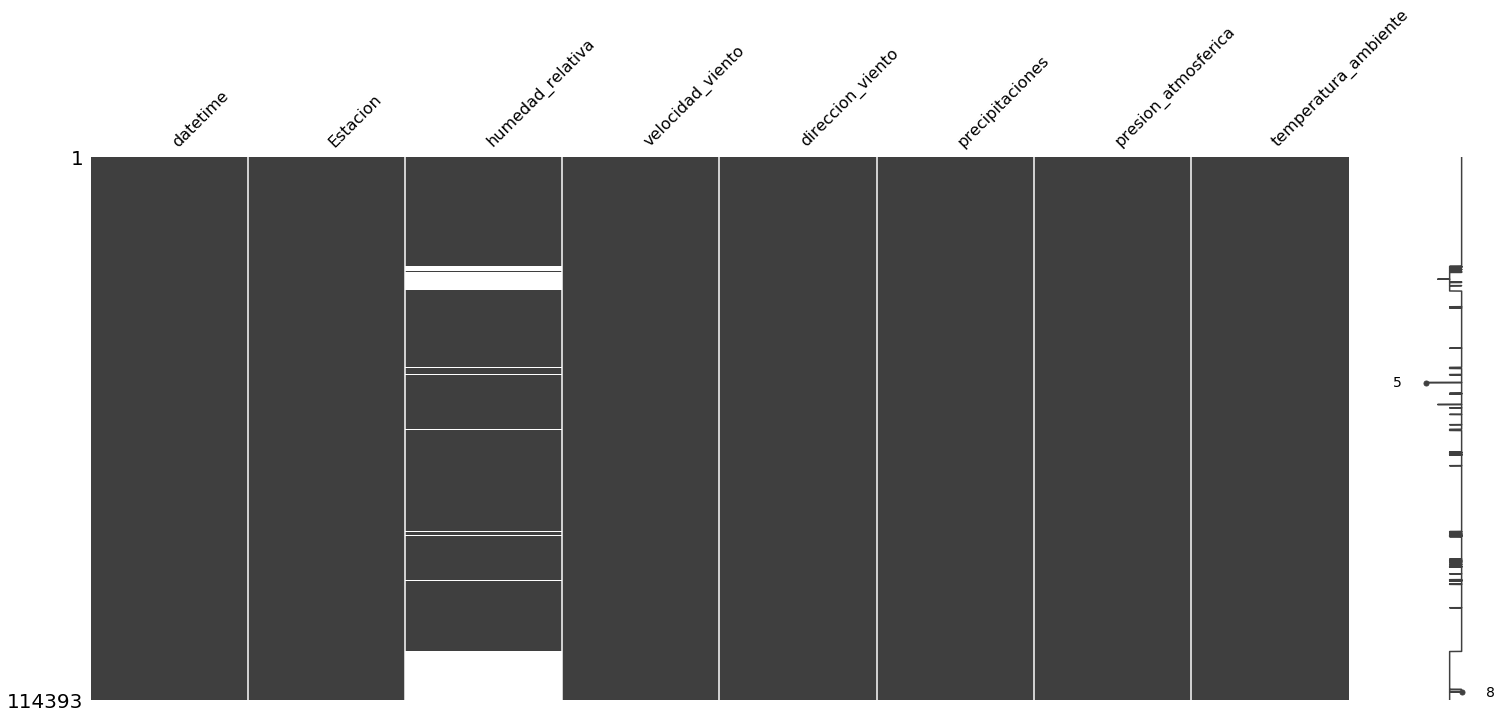

In [34]:
missingno.matrix(df_le)

In [37]:
df_le.dropna(how='all',subset=["humedad_relativa"], inplace=True)
df_le.dropna(how='all',subset=["temperatura_ambiente"], inplace=True)



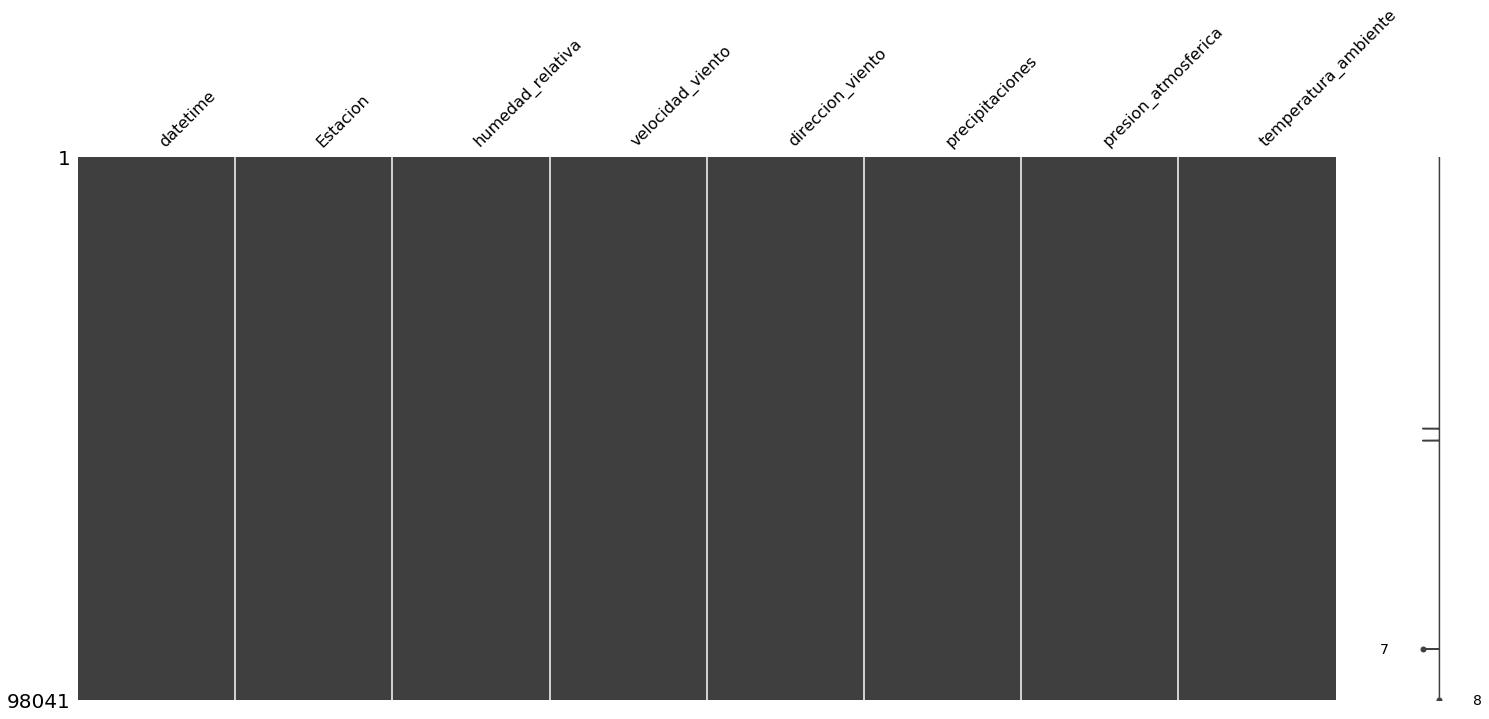

In [38]:
missingno.matrix(df_le)

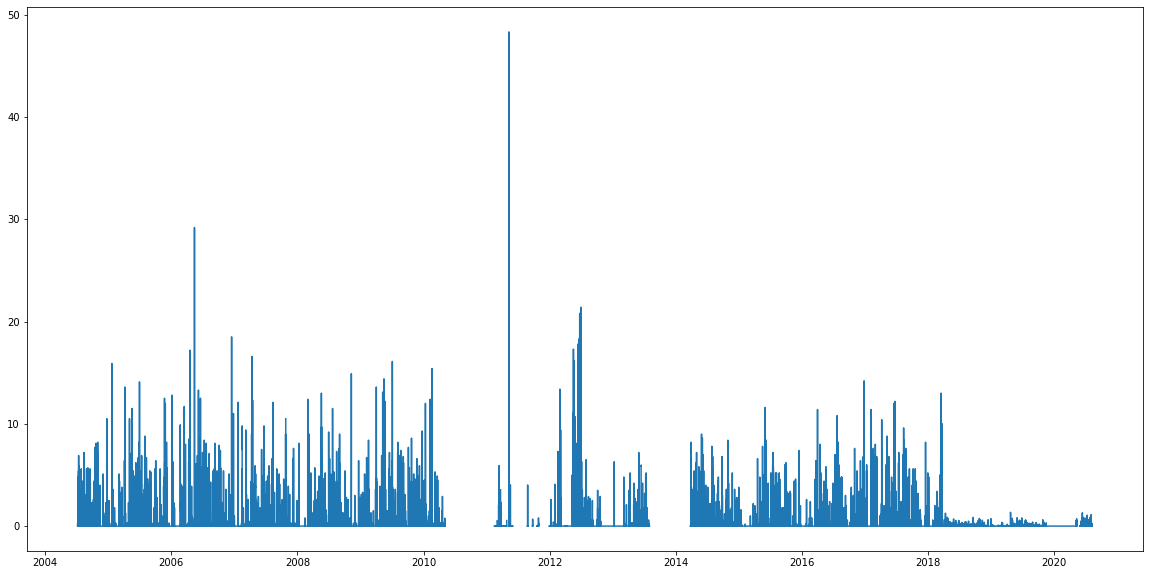

In [15]:
plt.figure(figsize=(20,10))
plt.plot(df_le['datetime'], df_le['precipitaciones'])

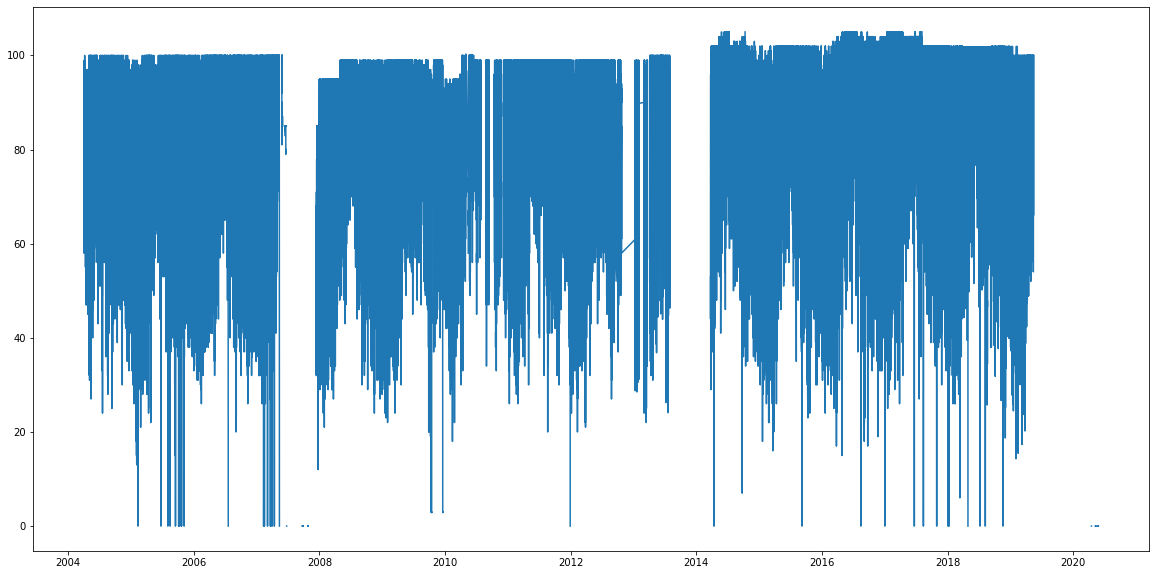

In [16]:
plt.figure(figsize=(20,10))
plt.plot(df_le['datetime'], df_le['humedad_relativa'])

## Padre Las Casas II's Station

In [12]:
path = r'C:\Users\user\Desktop\Universidad\Machine-Learning\Proyecto\Proyecto_ML_MP2.5\data\estacion-padre-las-casas-II' # use your path
padre_las_casas_files = glob.glob(path + "/*.csv")

In [13]:
#dataframe padre las casas
df_plc=get_station_dataframe(padre_las_casas_files)
df_plc

,datetime,Estacion,Direccion Viento 10m,Humedad Relativa 2m,Humedad Relativa 3m,Precipitaciones 2m,Precipitaciones 4m,Presion Atmosferica 2m,Presion Atmosferica 3m,Temperatura Ambiente 10m,Temperatura Ambiente 2m,Velocidad Viento 10m
0,2012-03-22 01:00:00,otoño,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2012-03-22 02:00:00,otoño,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2012-03-22 03:00:00,otoño,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2012-03-22 04:00:00,otoño,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2012-03-22 05:00:00,otoño,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
73506,2020-08-09 19:00:00,invierno,253.617,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
73507,2020-08-09 20:00:00,invierno,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
73508,2020-08-09 21:00:00,invierno,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
73509,2020-08-09 22:00:00,invierno,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


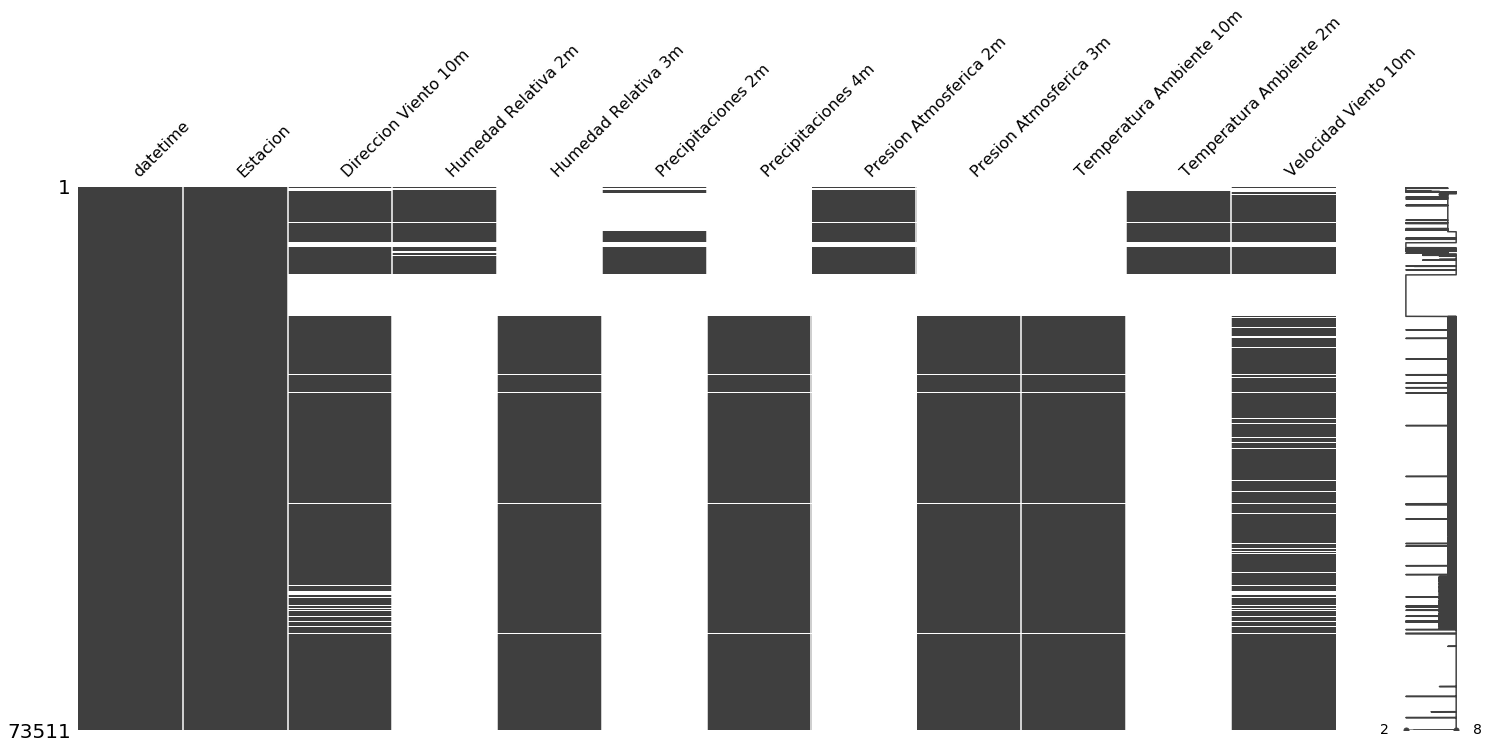

In [14]:
missingno.matrix(df_plc)

In [15]:
#Humedad Relativa
df_plc["humedad_relativa"] = df_plc["Humedad Relativa 2m"].combine_first(df_plc["Humedad Relativa 3m"]).astype(float)
df_plc= df_plc.drop(['Humedad Relativa 2m', 'Humedad Relativa 3m'], axis=1)

df_plc=df_plc.rename(columns={'Velocidad Viento 10m':'velocidad_viento','Direccion Viento 10m':'direccion_viento'})

#Precipitacion
df_plc["precipitaciones"] = df_plc["Precipitaciones 2m"].combine_first(df_plc["Precipitaciones 4m"]).astype(float)
df_plc= df_plc.drop(['Precipitaciones 4m','Precipitaciones 2m'], axis=1)
#Presion Atmosferica
df_plc["presion_atmosferica"] = df_plc["Presion Atmosferica 2m"].combine_first(df_plc["Presion Atmosferica 3m"]).astype(float)
df_plc= df_plc.drop(['Presion Atmosferica 2m','Presion Atmosferica 3m'], axis=1)
#Temperatura Ambiente 
df_plc["temperatura_ambiente"] = df_plc["Temperatura Ambiente 10m"].combine_first(df_plc["Temperatura Ambiente 2m"]).astype(float)
df_plc= df_plc.drop(['Temperatura Ambiente 10m','Temperatura Ambiente 2m'], axis=1)

#dropping rows where all the metereologic metrics are 'nan'
df_plc.dropna(how='all',subset=["humedad_relativa","velocidad_viento","direccion_viento","precipitaciones", "presion_atmosferica","temperatura_ambiente"], inplace=True)


In [16]:
df_plc=df_plc.rename(columns={'Velocidad Viento 10m':'velocidad_viento','Direccion Viento 10m':'direccion_viento'})


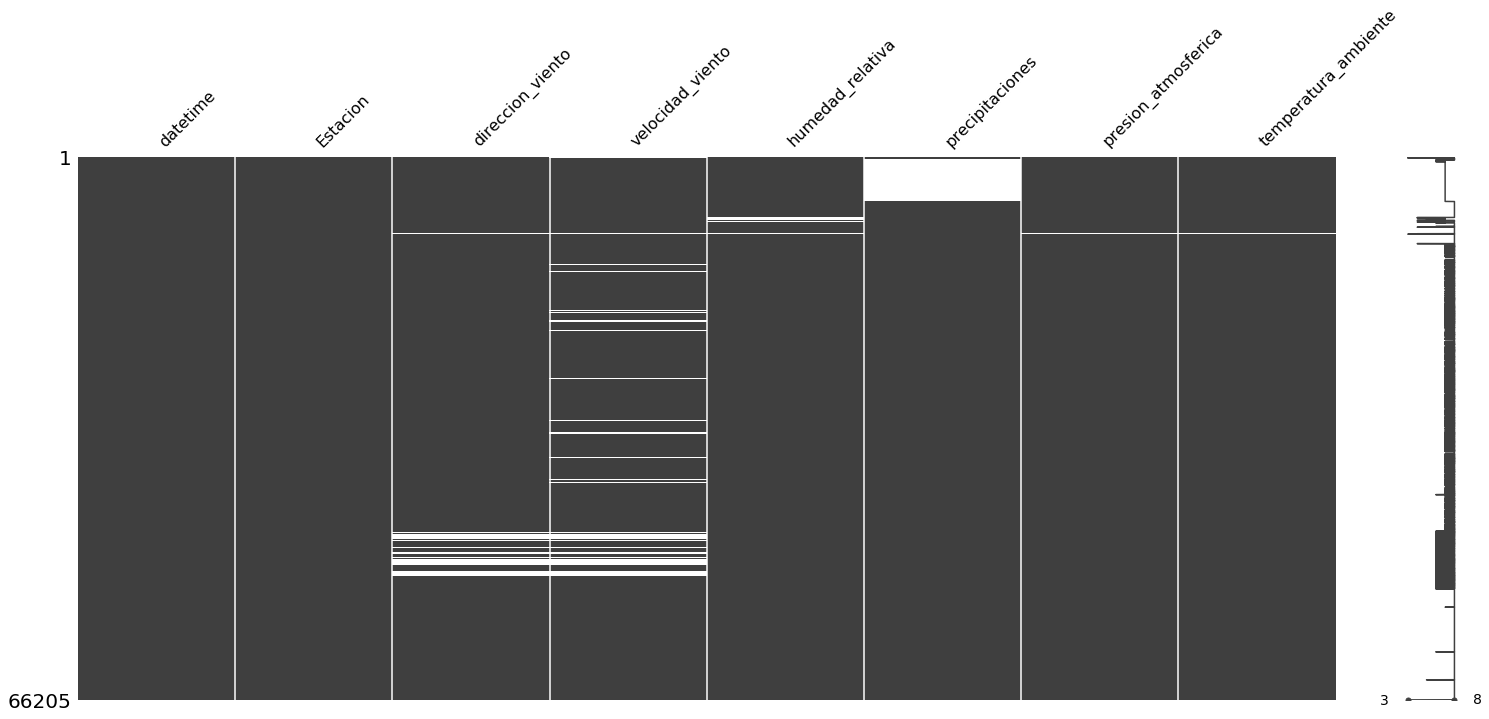

In [17]:
missingno.matrix(df_plc)

In [39]:
df_plc.dropna(how='all',subset=["velocidad_viento"], inplace=True)
df_plc.dropna(how='all',subset=["humedad_relativa"], inplace=True)
df_plc.dropna(how='all',subset=["precipitaciones"], inplace=True)




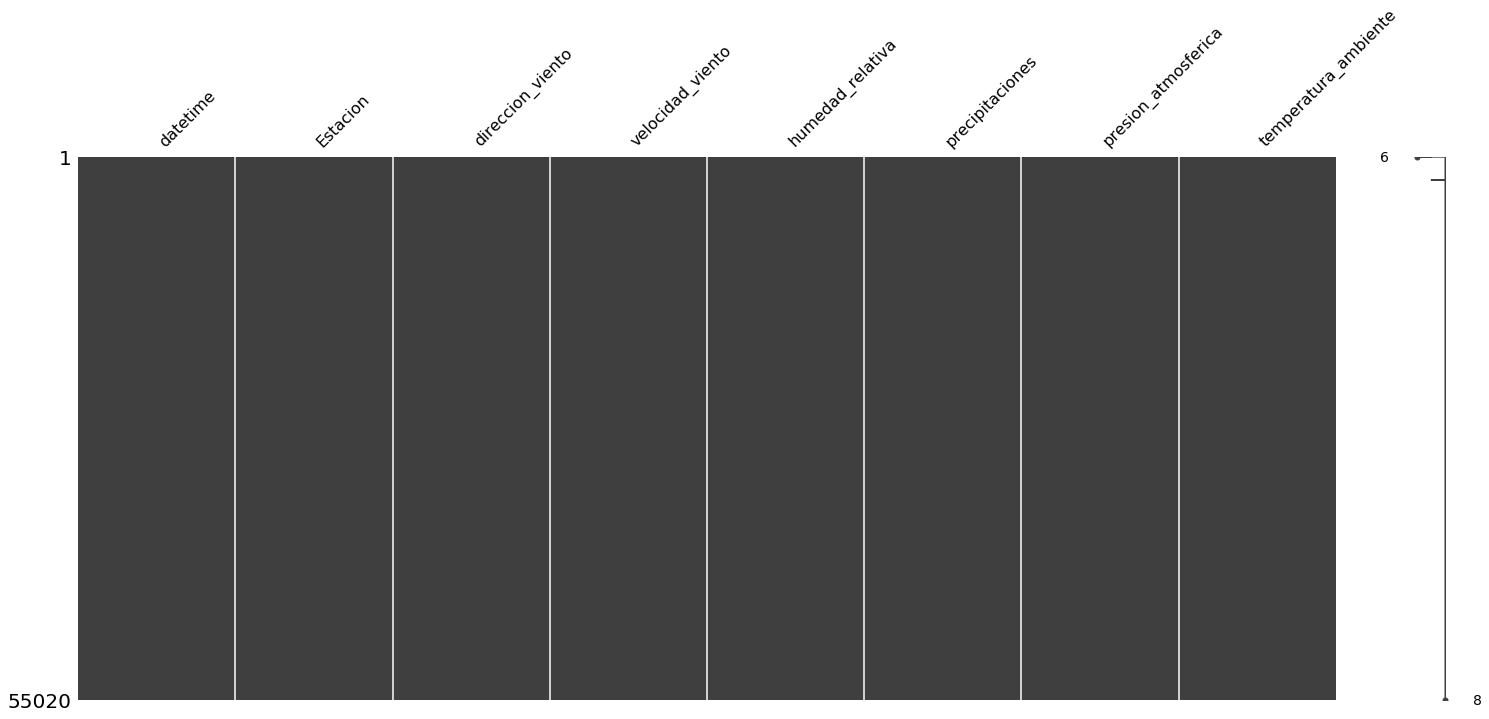

In [40]:
missingno.matrix(df_plc)

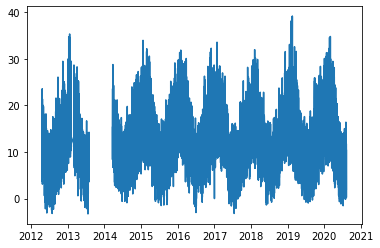

In [26]:
plt.plot(df_plc['datetime'],df_plc['temperatura_ambiente'])

## Ñielol's Station

In [20]:
path = r'C:\Users\user\Desktop\Universidad\Machine-Learning\Proyecto\Proyecto_ML_MP2.5\data\estacion-ñielol' # use your path
ñienol_files = glob.glob(path + "/*.csv")

In [23]:
#dataframe ñielol
df_nl=get_station_dataframe(ñienol_files)
df_nl

,datetime,Estacion,Direccion Viento 10m,Humedad Relativa 3m,Precipitaciones 4m,Presion Atmosferica 3m,Temperatura Ambiente 10m,Velocidad Viento 10m
0,2017-01-01 01:00:00,verano,0.0000,0.0,0.0,0.0,0.0,0.0
1,2017-01-01 02:00:00,verano,NaN,NaN,NaN,NaN,NaN,NaN
2,2017-01-01 03:00:00,verano,NaN,NaN,NaN,NaN,NaN,NaN
3,2017-01-01 04:00:00,verano,NaN,NaN,NaN,NaN,NaN,NaN
4,2017-01-01 05:00:00,verano,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
31578,2020-08-08 19:00:00,invierno,345.2000,NaN,NaN,NaN,NaN,NaN
31579,2020-08-08 20:00:00,invierno,352.8040,NaN,NaN,NaN,NaN,NaN
31580,2020-08-08 21:00:00,invierno,31.1378,NaN,NaN,NaN,NaN,NaN
31581,2020-08-08 22:00:00,invierno,NaN,NaN,NaN,NaN,NaN,NaN


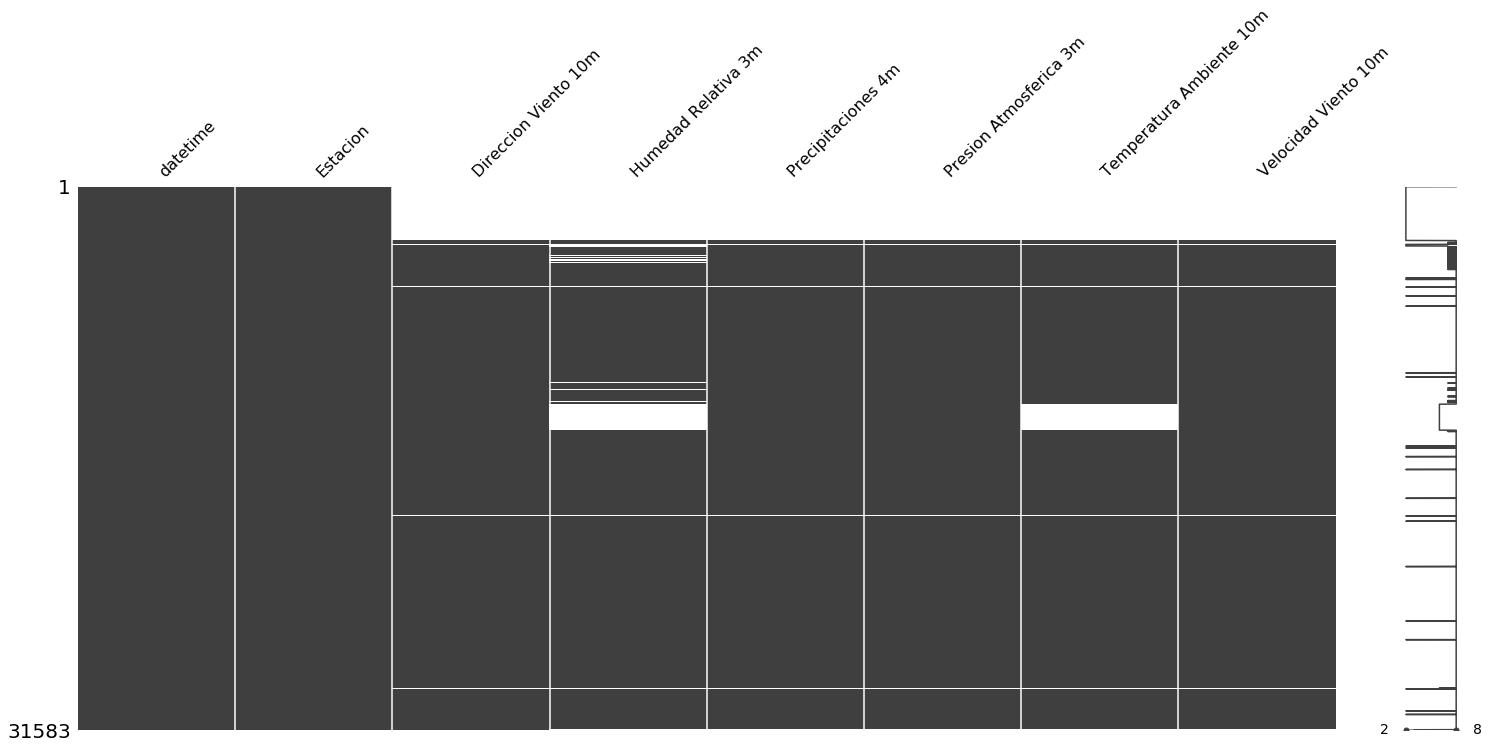

In [24]:
missingno.matrix(df_nl)

In [25]:
df_nl=df_nl.rename(columns={'Direccion Viento 10m':'direccion_viento','Humedad Relativa 3m': 'humedad_relativa', 'Precipitaciones 4m':'precipitaciones', 'Presion Atmosferica 3m':'presion_atmosferica','Temperatura Ambiente 10m':'temperatura_ambiente','Velocidad Viento 10m':'velocidad_viento'})

#dropping rows where all the metereologic metrics are 'nan'
df_nl.dropna(how='all',subset=["humedad_relativa","temperatura_ambiente"], inplace=True)

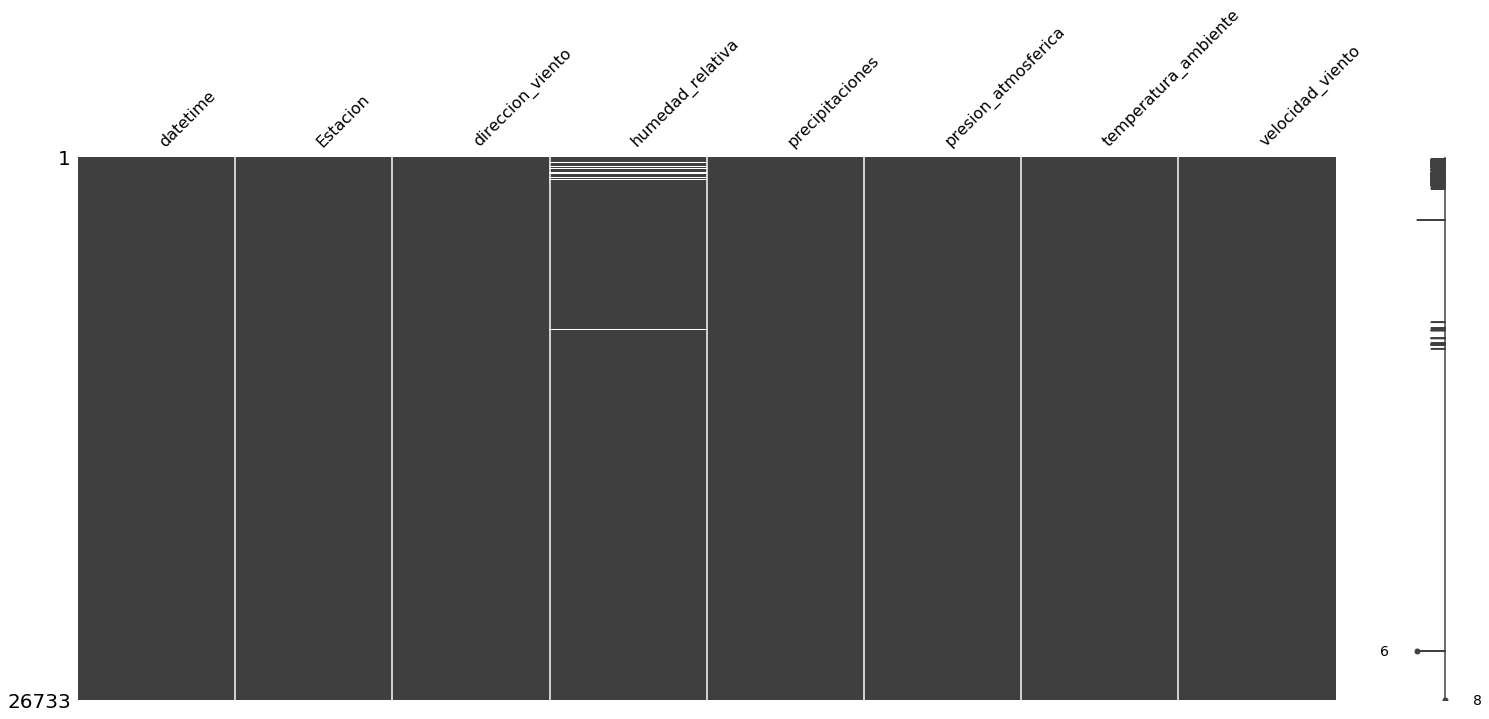

In [26]:
missingno.matrix(df_nl)

In [27]:
df_nl.dropna(how='all',subset=["humedad_relativa"], inplace=True)

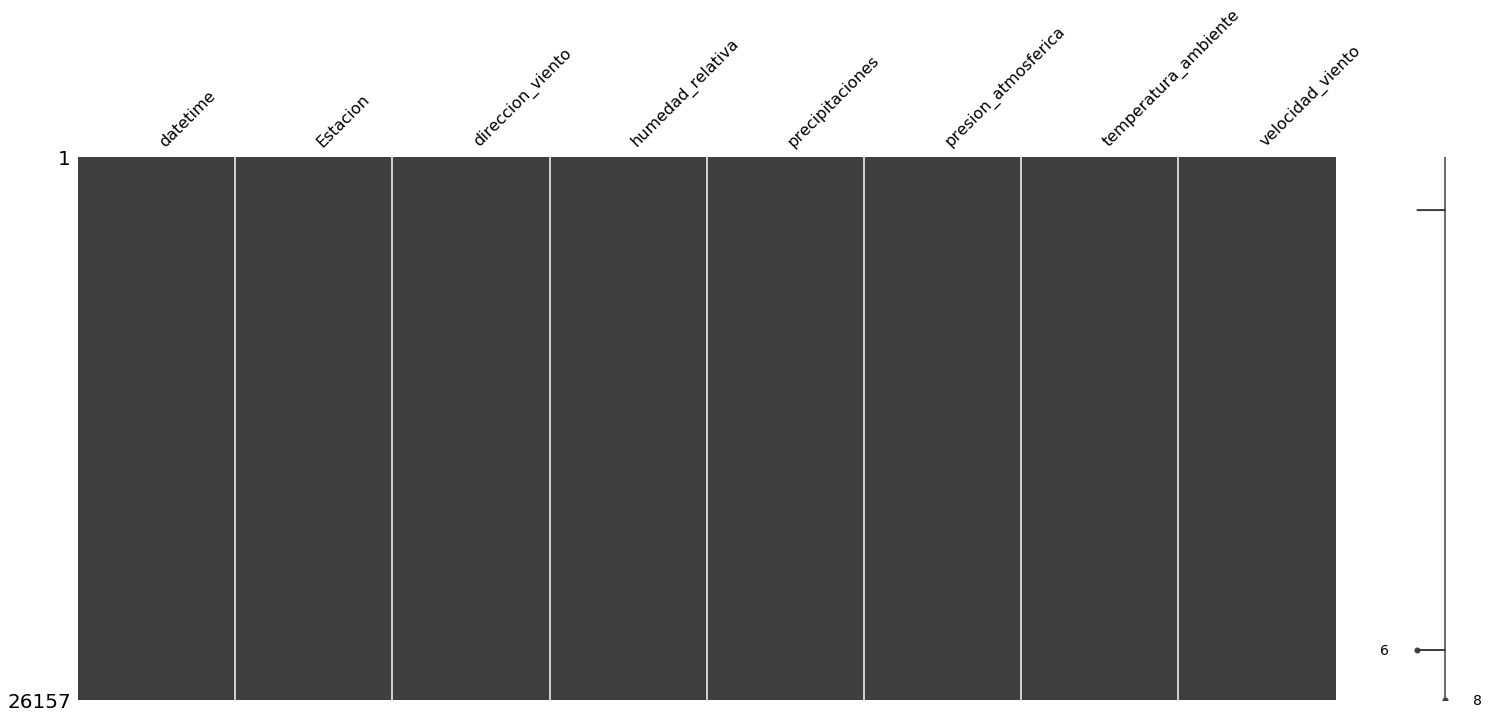

In [28]:
missingno.matrix(df_nl)

 
 Para tener el dataframe de Ñielol sin nans, se pasa de 31,583

## Changing non sensical values

In [29]:
#here plot

Probably due to sensor malfunction, there are some meteorological data that makes no sense. In this section we adress that problem.

In [41]:

df_le.loc[df_le.presion_atmosferica < 987, 'presion_atmosferica'] = 987
df_plc.loc[df_plc.presion_atmosferica < 987, 'presion_atmosferica'] = 987
df_nl.loc[df_nl.presion_atmosferica < 987, 'presion_atmosferica'] = 987

Text(0.5, 1.0, 'Temperatura Ambiente Las Encinas')

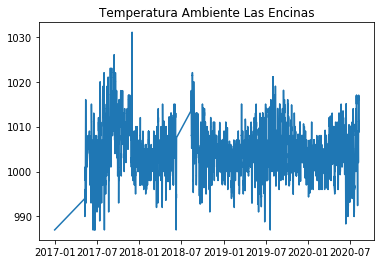

In [86]:


# Create just a figure and only one subplot
fig, ax = plt.subplots()
ax.plot(df_nl['datetime'], df_nl['presion_atmosferica'])   #Las Encinas
ax.set_title('Temperatura Ambiente Las Encinas')

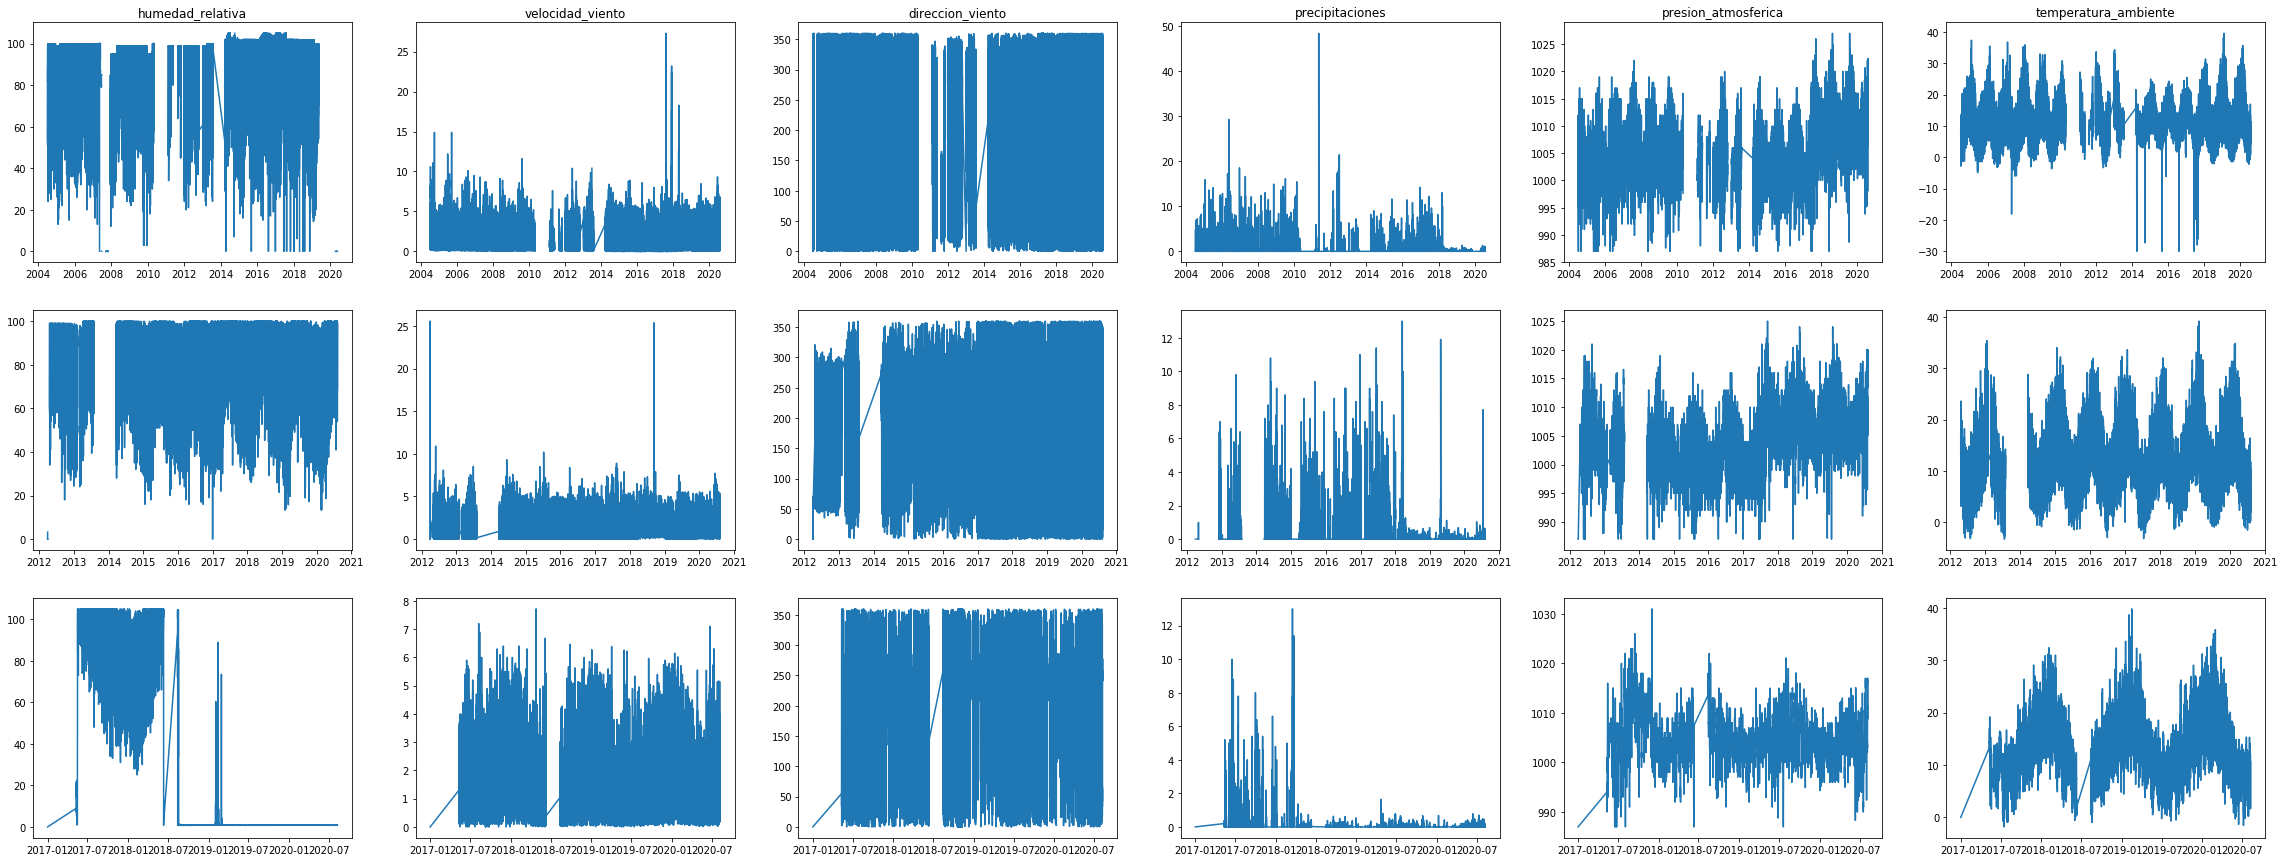

In [91]:
fig, axs =plt.subplots(3,6,figsize=(40,15))
i=0
for metric in df_le.columns[2:len(df_le.columns)]:
    axs[0, i].plot(df_le['datetime'], df_le[metric])   #Las Encinas
    axs[0,i].set_title(metric)
    axs[1, i].plot(df_plc['datetime'], df_plc[metric]) #Padre Las Casas
    axs[2, i].plot(df_nl['datetime'], df_nl[metric]) #Ñielol
    i+=1

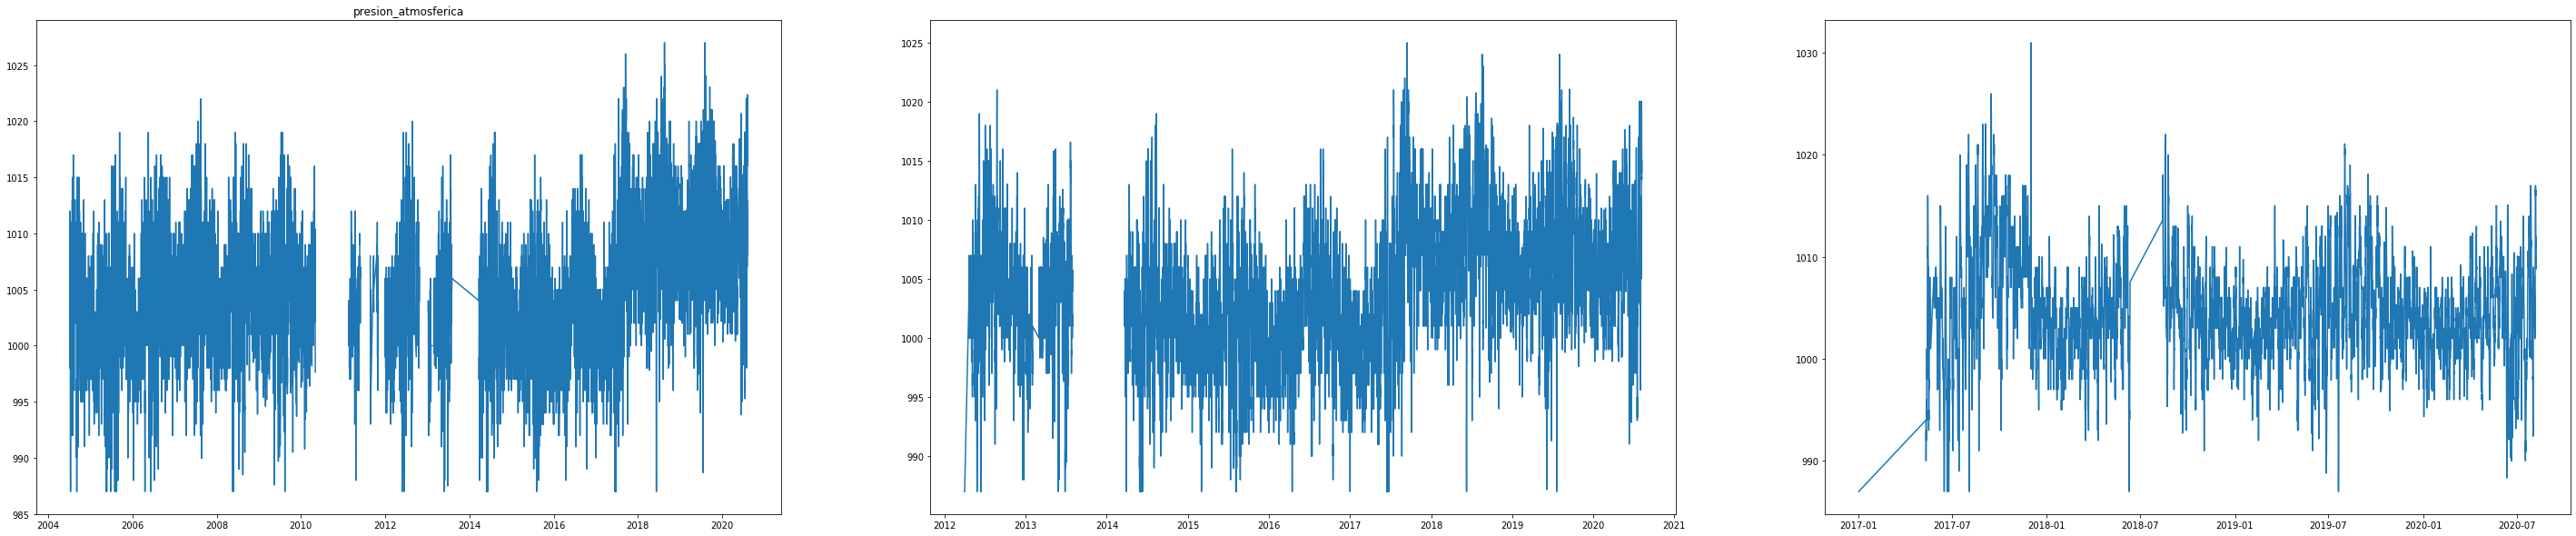

In [87]:
fig, axs=plt.subplots(1,3,figsize=(50,10))
metric='presion_atmosferica'
axs[0].plot(df_le['datetime'], df_le[metric])   #Las Encinas
axs[0].set_title(metric)
axs[1].plot(df_plc['datetime'], df_plc[metric]) #Padre Las Casas
axs[2].plot(df_nl['datetime'], df_nl[metric]) #Ñielol

## Concatenating dataframes into a 'Temuco Dataframe'

In [42]:
temuco_df = pd.concat([df_le,df_plc,df_nl])

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [43]:
temuco_df

,Estacion,datetime,direccion_viento,humedad_relativa,precipitaciones,presion_atmosferica,temperatura_ambiente,velocidad_viento
2351,invierno,2004-07-07 00:00:00,247.000,82.000000,0.000000e+00,1010.00,9.20000,1.60000
2352,invierno,2004-07-07 01:00:00,272.000,82.000000,0.000000e+00,1010.00,8.79999,1.10000
2353,invierno,2004-07-07 02:00:00,275.000,83.000000,0.000000e+00,1010.00,8.79999,1.20000
2354,invierno,2004-07-07 03:00:00,303.000,85.000000,0.000000e+00,1010.00,7.89999,0.50000
2355,invierno,2004-07-07 04:00:00,297.000,89.000000,0.000000e+00,1010.00,7.60000,0.40000
...,...,...,...,...,...,...,...,...
31545,invierno,2020-08-07 10:00:00,243.315,0.772750,0.000000e+00,1011.00,5.58800,1.87391
31546,invierno,2020-08-07 11:00:00,249.365,0.786333,6.726230e-44,1010.67,7.00333,2.56295
31547,invierno,2020-08-07 12:00:00,248.067,0.809417,4.484160e-44,1010.00,8.74408,2.69903
31548,invierno,2020-08-07 13:00:00,246.647,0.817083,6.726230e-44,1009.56,10.03500,3.16925


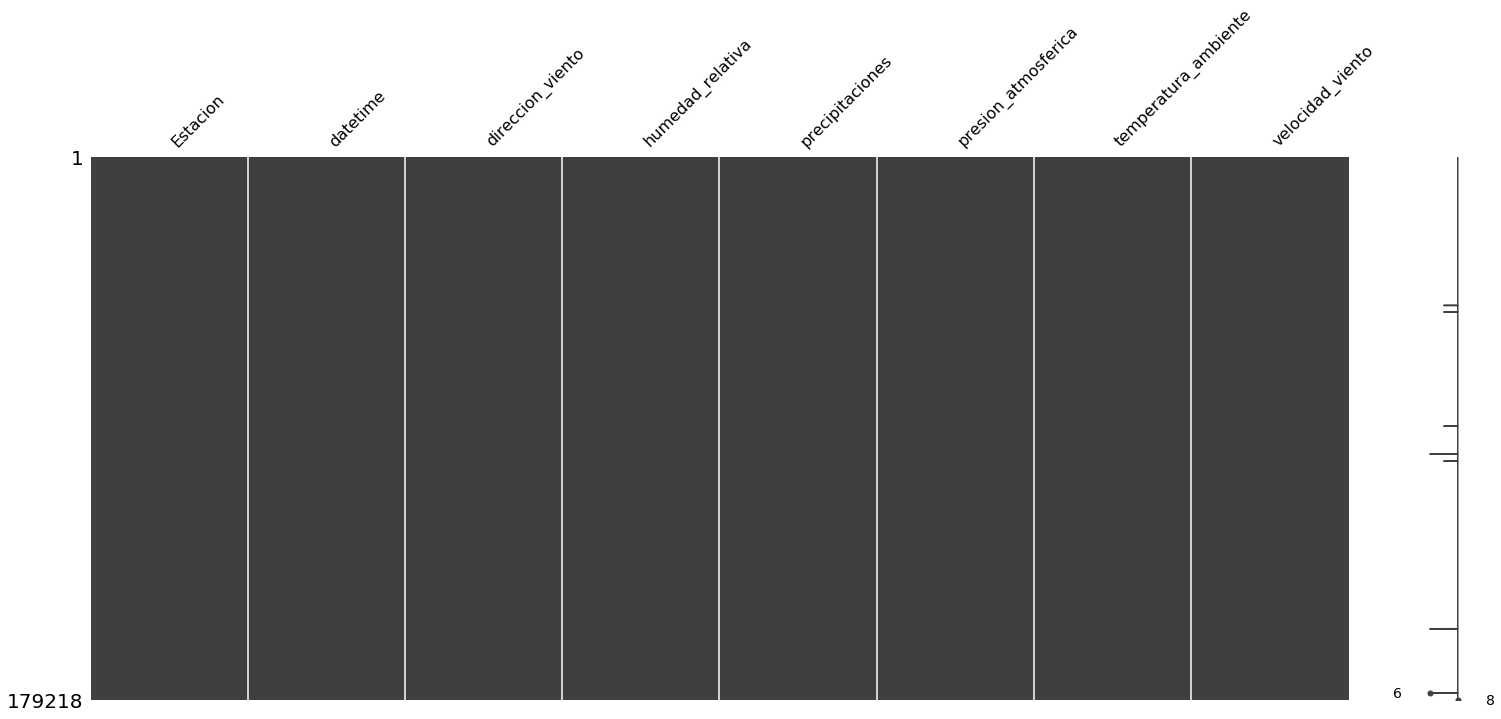

In [44]:
missingno.matrix(temuco_df)

## Saving data

Save the data so it can be fed into ML predictive models.

In [46]:
temuco_df.to_csv(r'C:\Users\user\Desktop\Universidad\Machine-Learning\Proyecto\Proyecto_ML_MP2.5\data\cleaned_data.csv', index = False)